In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from fns import *
from syntheticdata import synthetic_generation

In [2]:
training_array = []
validation_array = []
testing_array = []


In [3]:
class Synthetic(object):
    def __init__(self, N=10000):
        
        DATAPATH = "/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00"
        CASEPATH = [DATAPATH + '/' + s for s in os.listdir(DATAPATH) if s != '.DS_Store']

        self.needlepaths = []
        self.casepaths = []
        for case in CASEPATH[:N]:
            print(case+'/needle-Manual_*')
            needlepath = glob.glob(case+'/needle-*-Manual_*')
            casepath = [case + '/' + s for s in os.listdir(case) if 'case' in s]
            self.needlepaths = self.needlepaths + needlepath
            self.casepaths = self.casepaths + casepath
        print('Number of Needles:',len(self.needlepaths))
        print("Number of Cases:",len(self.casepaths))
    
        #load needles
        self.needles = []
        for needlepath in self.needlepaths[:N]:
            needleimg = nrrd.read(needlepath)
            needlearray = needleimg[0]
            needlearray[needlearray != 0] = 1
            self.needles.append(needlearray)
        
        #load cases
        self.cases = []
        for casepath in self.casepaths[:N]:
            caseimg = nrrd.read(casepath)
            casearray = caseimg[0]
            self.cases.append(casearray)

            
    def labelmap_resize(self, data, shape):
        """
        Crops from center
        """
        offset0 = (data.shape[0] - shape[0])//2
        offset1 = (data.shape[1] - shape[1])//2
        
        if data.shape[2] >= shape[2]:
            offset2 = (data.shape[2] - shape[2])//2
            out = data[offset0:offset0+shape[0], offset1:offset1+shape[1], offset2:offset2+shape[2]]
        else:
            offset2 = (shape[2] - data.shape[2])//2
            out = np.zeros(shape,int)
            out[:,:,offset2:offset2+data.shape[2]] = data[offset0:offset0+shape[0], offset1:offset1+shape[1], :]
            
        return out

    
    def get_array(self, num_needles, degree, shape, occult=True, std=None, mean=None):
        #################
        ## generate synthetic labelmap
        ##################
        random.shuffle(self.needles)
        labelmap_syn = np.zeros(shape,int)## int may need to be replaced by float
        count_needle=0
        i=-1
        while count_needle < num_needles:
            i+=1
            needle = self.needles[np.random.randint(len(self.needles))]
            xs, ys, zs = np.where(needle == 1)
            I = np.asarray([[x, y, z] for x, y, z in zip(xs,ys,zs)])
            I = np.transpose(I)
            x_angle = (random.random()-0.5)*2 *degree*np.pi/180
            y_angle = (random.random()-0.5)*2 *degree*np.pi/180
            z_angle = (random.random()-0.5)*2 *degree*np.pi/180
            R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
            try:
                M = np.transpose(np.dot(R,I)).astype(int)
            except ValueError:
                print("Empty Needle",self.needlepaths[i])
                continue
            needle_rot = np.zeros(needle.shape,int)
            for x,y,z in M:
                try:
                    needle_rot[x][y][z] = 1
                except IndexError:
                    continue
            
            
            
            needle_crop = self.labelmap_resize(needle_rot, shape)
            if np.sum(needle_crop)>700:
                count_needle+=1
                labelmap_syn = labelmap_syn + needle_crop   ## There will be chance of needle overlap
            
        if occult:
            square = np.ones((20,20,20))
            squares = np.zeros(shape)
            for i in range(20):
                sq = np.where(square!=0)
                sqx = sq[0] + np.random.randint(0,148)
                sqy = sq[1] + np.random.randint(0,148)
                sqz = sq[2] + np.random.randint(0,148)
                squares[np.clip(sqx,0,shape[0]-1), np.clip(sqy,0,shape[1]-1), np.clip(sqz,0,shape[2]-1)] = 1
            
        #################
        ## generate synthetic case
        ##################
        if std == None:
            std = np.std(self.cases[0])
        if mean == None:
            mean = np.mean(self.cases[0])
        case_syn = np.random.normal(np.log(std), mean, shape)
        case_syn = gaussian_filter(case_syn, sigma=6)
        case_syn2 = np.random.normal(np.log(std), mean, shape)
        case_syn2 = gaussian_filter(case_syn, sigma=3)
        case_syn1 = np.random.normal(np.log(std), mean, shape)
        case_syn1 = gaussian_filter(case_syn, sigma=2)
        case_syn = case_syn1*case_syn2*case_syn
        case_syn /= np.mean(case_syn)
        case_syn *= mean
        
        
        case_syn = np.clip(case_syn,0,500)
        VAL_NEEDLE = np.random.randint(np.int(np.mean(case_syn)/3))
        if occult:
            case_syn[(labelmap_syn != 0) & (squares == 0)] = VAL_NEEDLE
        else:
            case_syn[labelmap_syn != 0] = VAL_NEEDLE
        case_syn = gaussian_filter(case_syn, sigma=0.7)
    
        return labelmap_syn,case_syn

In [5]:
synthetic = Synthetic(N=10000)

/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/033/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/077/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/076/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/014/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/062/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/044/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/022/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/034/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/008/needle-Manual_*
/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-

In [9]:
from numpy import random
import sys
sys.path.append('../')
import os
import numpy as np
import random
from transforms3d.euler import euler2mat, mat2euler
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib notebook')
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform
import nrrd
from scipy.ndimage.filters import gaussian_filter
import glob

In [23]:
Num_Training = 600
Num_Validation = 30
Num_Testing = 30

SAVEPATH = "/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_synthetic_occulted/"
NUMPYPATH = SAVEPATH + "numpy/"
NRRDPATH = SAVEPATH + "nrrd/"
numberOfCases = len(glob.glob(NUMPYPATH + "training_labelmap*")) 
try:
    os.mkdir(SAVEPATH)
    os.mkdir(NUMPYPATH)
    os.mkdir(NRRDPATH)
except:
    pass

for num in tnrange(Num_Training):
    while True:
        labelmap, case = synthetic.get_array(num_needles=20, degree=10, shape = (148, 148, 148))
        labelmap[labelmap != 0] = 1 
        unique, counts = np.unique(labelmap, return_counts = True)
        counts = np.sum(labelmap)
        print("Num: ", num, counts)
        if counts >= 100 and counts <= 30000:
                training_array.append([case, labelmap])
                np.save(NUMPYPATH + "training_labelmap{}.npy".format(numberOfCases + num+1), labelmap)
                np.save(NUMPYPATH + "training_case{}.npy".format(numberOfCases + num+1), case)
                nrrd.write(NRRDPATH + "training_labelmap{}.nrrd".format(numberOfCases + num+1), labelmap.astype(np.uint8))
                nrrd.write(NRRDPATH + "training_case{}.nrrd".format(numberOfCases + num+1), case)
                break
    
print('*'* 20)

for num in tnrange(Num_Validation):
    while True:
        labelmap, case = synthetic.get_array(num_needles=20, degree=10, shape = (148, 148, 148))
        labelmap[labelmap != 0] = 1 
        counts = np.sum(labelmap)
        if counts >= 100 and counts <= 30000:
                validation_array.append([case, labelmap])
                np.save(NUMPYPATH + "validation_labelmap{}.npy".format(num+1), labelmap)
                np.save(NUMPYPATH + "validation_case{}.npy".format(num+1), case)
                nrrd.write(NRRDPATH + "validation_labelmap{}.nrrd".format(num+1), labelmap.astype(np.uint8))
                nrrd.write(NRRDPATH + "validation_case{}.nrrd".format(num+1), case)
                break

print('*'*20)    
    
for num in tnrange(Num_Testing):
    while True:
        labelmap, case = synthetic.get_array(num_needles=20, degree=10, shape = (148, 148, 148))
        labelmap[labelmap != 0] = 1 
        unique, counts = np.unique(labelmap, return_counts = True)
        counts = np.sum(labelmap)
        if counts >= 100 and counts <= 30000:
                testing_array.append([case, labelmap])
                np.save(NUMPYPATH + "testing_labelmap{}.npy".format(num+1), labelmap)
                np.save(NUMPYPATH + "testing_case{}.npy".format(num+1), case)
                nrrd.write(NRRDPATH + "testing_labelmap{}.nrrd".format(num+1), labelmap.astype(np.uint8))
                nrrd.write(NRRDPATH + "testing_case{}.nrrd".format(num+1), case)
                break

                


Num:  0 17213
Num:  1 16783
Num:  2 17503
Num:  3 3136561
Num:  3 18259
Num:  4 17435
Num:  5 17058
Num:  6 17500
Num:  7 16761
Num:  8 16783
Num:  9 17087
Num:  10 17061
Num:  11 16918
Num:  12 2994910
Num:  12 17084
Num:  13 3144128
Num:  13 2913832
Num:  13 17819
Num:  14 18166
Num:  15 17310
Num:  16 17046
Num:  17 3148515
Num:  17 3117918
Num:  17 16964
Num:  18 17528
Num:  19 3215510
Num:  19 17533
Num:  20 17242
Num:  21 16916
Num:  22 16866
Num:  23 17295
Num:  24 18070
Num:  25 3151732
Num:  25 17191
Num:  26 17688
Num:  27 3238322
Num:  27 17080
Num:  28 3233062
Num:  28 17683
Num:  29 16865
Num:  30 17541
Num:  31 18294
Num:  32 17428
Num:  33 17740
Num:  34 18392
Num:  35 3226657
Num:  35 3114898
Num:  35 2917158
Num:  35 17601
Num:  36 16816
Num:  37 17172
Num:  38 18044
Num:  39 17096
Num:  40 16954
Num:  41 3168033
Num:  41 16605
Num:  42 17526
Num:  43 17835
Num:  44 16426
Num:  45 3209185
Num:  45 17499
Num:  46 17802
Num:  47 17461
Num:  48 16895
Num:  49 17817
Num: 

KeyboardInterrupt: 

In [22]:
numberOfCases = len(glob.glob(NUMPYPATH + "training_labelmap*"))

300

0

In [11]:

# assert len(training_array) == Num_Training
# for num, array in enumerate(training_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "training_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "training_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "training_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "training_case{}.nrrd".format(num+1), case)
    
# assert len(validation_array) == Num_Validation
# for num, array in enumerate(validation_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "validation_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "validation_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "validation_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "validation_case{}.nrrd".format(num+1), case)
    
# assert len(testing_array) == Num_Testing
# for num, array in enumerate(testing_array):
#     case = array[0].astype(np.int32)
#     labelmap = array[1].astype(np.int32)
#     np.save(NUMPYPATH + "testing_labelmap{}.npy".format(num+1), labelmap)
#     np.save(NUMPYPATH + "testing_case{}.npy".format(num+1), case)
#     nrrd.write(NRRDPATH + "testing_labelmap{}.nrrd".format(num+1), labelmap)
#     nrrd.write(NRRDPATH + "testing_case{}.nrrd".format(num+1), case)

<IPython.core.display.Javascript object>


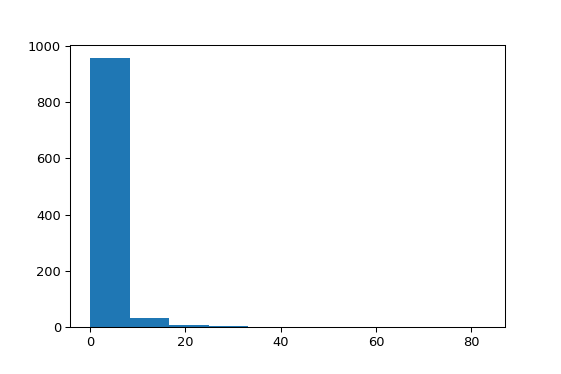

(array([ 956.,   32.,    7.,    3.,    1.,    0.,    0.,    0.,    0.,    1.]),
 array([  2.36686875e-02,   8.32326030e+00,   1.66228519e+01,
          2.49224435e+01,   3.32220352e+01,   4.15216268e+01,
          4.98212184e+01,   5.81208100e+01,   6.64204016e+01,
          7.47199932e+01,   8.30195848e+01]),
 <a list of 10 Patch objects>)

In [4]:
# plt.hist(np.random.lognormal(0,1.3,1000))